## Run Algorithm 3 on stationary OU, with J imposed at middle and final time

In [45]:

import matplotlib.pyplot as plt
import numpy as np
import math


dim = 1
walkers = 50   # size of the interacting particle system
m = 20   # number of purturbations for FI estimator
sigma = 0.1   # size of perturbation


hyperparams={'dt': 0.01, 'num_steps': 10, 'num_training_steps' : 200}

# OU as reference: dXt = - beta X_t dt + sqrt{2}dW_t
# stationary distribution \nu is N(0,1/beta) with variance = 1/beta
beta = 0.5
X_init = np.random.normal(0,1/math.sqrt(beta),walkers)  # initialize walkers from Gaussian


grad_V = lambda x: beta*x   # gradient of reference potential
delta_log_nu = lambda x: -beta*dim   


# likelihood function: maybe x(middle_point)=-3, x(final_point = 3)? So J is 0 for most t
# without J, one expect N(0,1/beta)
tol = 0.01


(50, 1)
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 31329.01171875
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 142.54200744628906
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 31.35515785217285
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 83.66650390625
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 34.557552337646484
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 45.54058074951172
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 54.879398345947266
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 47.224403381347656
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 65.20899200439453
(1, 1) shape of X
(20, 1) shape of Y
(1,) shape of X v
Train loss: 42.580810546875


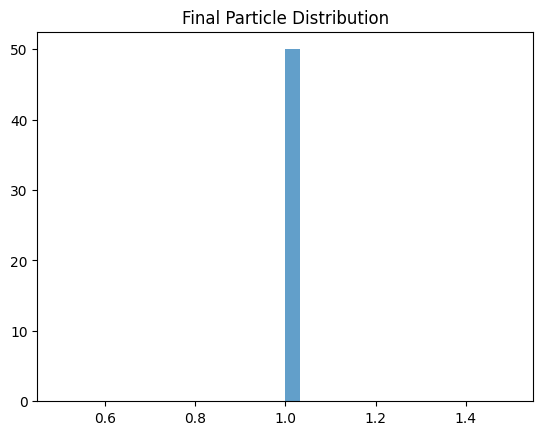

In [48]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import sys
sys.path.append("..")
from src.nn import MLP, train

key = jax.random.PRNGKey(0)

h = hyperparams['dt']
T = hyperparams['num_steps']*hyperparams['dt']
num_steps = hyperparams['num_steps']
num_training_steps = hyperparams['num_training_steps']

# Set up the neural network
mlp_dims = [3, 20, 20, 1]
model_key, key = jax.random.split(key)
phi = MLP(mlp_dims, key=model_key)
optimizer = optax.adam(1e-3)


# Initialize particles
X_particles = jnp.array(X_init).reshape(-1, 1)  # shape (n, 1)

print(X_particles.shape)

def L_theta(X, grad_V):

    # Qijia: check if the delta log nu part is correct
    return jnp.mean(jax.vmap(lambda x: 0.5 * jnp.linalg.norm(grad_V(x))**2 + delta_log_nu(x))(X))


def R_theta(X, m, sigma, key):
    X = jnp.expand_dims(X, axis=0)
    print(X.shape, "shape of X")
    n = X.shape[0]
    Y = X + sigma * jax.random.normal(key, (m, n))
    print(Y.shape, "shape of Y")
    diff = Y - X
    return jnp.mean(jax.vmap(lambda k: jnp.linalg.norm(k)**2 / (2 * sigma ** 4))(diff))

def J_t(X):
    print(X.shape, "shape of X v")
    # specifically for 1D case!!
    return (1/2.0)*(1/tol**2)*(X[0] - 1)**2

def make_loss(rkey):
    def loss(phi, X, t, s):
        X_proposed = jax.vmap(jax.grad(lambda x: phi(x,  t, s)[0]))(X)
        term1 =  (1/(2*h**2)) * (jnp.mean(jax.vmap(lambda x,y: (x-y).dot(x-y))(X_proposed, X)))
        term2 = jnp.mean(jax.vmap(lambda x: R_theta(x, m, sigma, rkey) + (2/h)*J_t(x))(X_proposed))
        term3 = L_theta(X_proposed, grad_V)
        return term1 + term2 + term3
    return loss

# Main loop
for step in range(num_steps):
    t = step * h
    t_input = jnp.ones((1,)) * t
    s_input = jnp.ones((1,)) # a placeholder variable

    rkey = jax.random.fold_in(key, step)

    # new phi: but is it phi(\cdot, x)?
    phi = train(make_loss(rkey), phi, optimizer, num_training_steps, X_particles, jnp.ones((1,))*t, s_input)

    X_particles = jax.vmap(jax.grad(lambda x: phi(x,  t_input, s_input)[0]))(X_particles)


# After loop, X_particles contains the final samples
plt.hist(np.array(X_particles).flatten(), bins=30, alpha=0.7)
plt.title('Final Particle Distribution')
plt.show()